#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import category_encoders as ce
import arviz as az
import pymc3 as pm
from theano import shared
from sklearn import preprocessing

In [2]:
df = pd.read_csv('/home/matt/Documents/cortex_Push.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientId                                      54039 non-null  int64  
 1   Program Id                                    54039 non-null  int64  
 2   Program Name                                  54039 non-null  object 
 3   Retailers                                     54039 non-null  object 
 4   TacticId                                      54039 non-null  int64  
 5   Tactic                                        54039 non-null  object 
 6   CategoryId                                    54039 non-null  int64  
 7   Tactic Category                               54039 non-null  object 
 8   VendorId                                      53135 non-null  float64
 9   Vendor                                        54039 non-null 

Pandas dataframes will have string, int, and float columns. The following
three sections will look for columns that need to be fixed or dropped altogether

In [3]:
# these drop column snippets are not used often here,
# but have been useful, especially with large datasets

# df = df.drop([], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()
print(df_cat.nunique())

There are 9 categorical variables

The categorical variables are :

 ['Program Name', 'Retailers', 'Tactic', 'Tactic Category', 'Vendor', 'Tactic Start Date', 'Tactic End Date', 'Brand', 'RMN']
Program Name         0.0
Retailers            0.0
Tactic               0.0
Tactic Category      0.0
Vendor               0.0
Tactic Start Date    0.0
Tactic End Date      0.0
Brand                0.0
RMN                  0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Program Name       54039 non-null  object
 1   Retailers          54039 non-null  object
 2   Tactic             54039 non-null  object
 3   Tactic Category    54039 non-null  object
 4   Vendor             54039 non-null  object
 5   Tactic Start Date  54039 non-null  object
 6   Tactic End Date    54039 non-null  object
 7   Brand              54039 non-n

In [4]:
df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

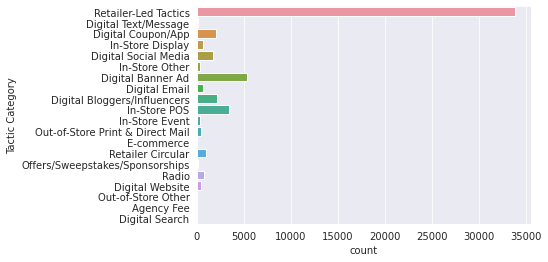

In [5]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

In [6]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 9 integer variables

The integer variables are :

 ['ClientId', 'Program Id', 'TacticId', 'CategoryId', 'Total Impressions for Tactic', 'BrandId', 'Nielsen_Week_Year', 'RMN', 'Weeks']
ClientId                        0
Program Id                      0
TacticId                        0
CategoryId                      0
Total Impressions for Tactic    0
BrandId                         0
Nielsen_Week_Year               0
RMN                             0
Weeks                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ClientId                      54039 non-null  int64
 1   Program Id                    54039 non-null  int64
 2   TacticId                      54039 non-null  int64
 3   CategoryId                    54039 non-null  int64
 4   Total Impressions for Tactic  54

In the below section we address the large number of missing values and also
the columns consisting entirely of zeroes, and drop them accordingly

In [7]:
df = df.drop(
        ['Base $', 'Incr $', 'Base Units', 'Incr Units',
         '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
         'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 24 float variables

The float variables are :

 ['VendorId', 'Total Tactic Spend', 'Total Tactic Insertion Cost', 'Total Tactic Redemption Cost', 'StoreCount', 'Impressions per Week', 'Brand Share of Program Budget', 'Brand Share of Total Tactic Spend', 'Brand Share of Tactic Insertion Cost', 'Brand Share of Tactic Redemption Cost', 'Weekly Brand Share of Total Tactic Spend', 'Weekly Brand Share of Tactic Insertion Cost', 'Weekly Brand Share of Tactic Redemption Cost', 'Total Sales', 'Units', 'Avg Unit Price', 'Any Promo Units', '%ACV Distribution', 'Any Promo %ACV', 'Disp w/o Feat %ACV', 'Feat & Disp %ACV', 'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Number of UPCs Selling']
Total Sales               62.036677
Units                     62.036677
Avg Unit Price            62.021873
Any Promo Units           62.021873
%ACV Distribution         62.099595
Any Promo %ACV            62.099595
Disp w/o Feat %ACV        62.099595
Feat & Disp %ACV          62.099595
Feat w/o Disp 

In [8]:
df = df.drop(
        ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
         'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
df_num.describe()

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,5.403900e+04,54039.000000,54039.000000,54039.000000,54031.000000,54039.000000,54039.000000,5.403900e+04,54039.000000,54039.000000,...,2.051500e+04,20523.000000,2.052300e+04,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20523.000000
mean,3.408857e+07,33927.000842,27540.179030,6386.821813,1033.474764,0.212513,8.902885,3.044121e+06,0.239102,7075.707566,...,1.984949e+05,5.651272,6.032207e+04,86.373085,45.409581,2.082658,0.820302,17.774523,36.872715,16.736686
std,3.680617e+08,61813.987485,61974.946222,12328.696054,1304.144639,0.409090,5.067866,3.048686e+07,0.291679,14125.204066,...,4.354113e+05,2.231451,1.662932e+05,25.044837,33.745145,5.432150,3.497597,27.201852,31.021937,16.984060
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.331000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.269400e+04,8714.000000,4494.000000,0.000000,0.000000,0.000000,6.000000,7.064667e+03,0.056904,635.431163,...,2.088150e+04,4.000000,2.202813e+03,91.901000,12.753000,0.000000,0.000000,0.000000,7.571000,6.000000
50%,3.000000e+05,20000.000000,10480.890000,0.000000,0.000000,0.000000,8.000000,3.739900e+04,0.123091,2291.429059,...,7.331000e+04,5.149000,1.539920e+04,98.872000,43.668000,0.000000,0.000000,0.900000,30.984000,11.000000
75%,3.800838e+06,40000.000000,29994.800000,9750.000000,2277.000000,0.000000,12.000000,5.371706e+05,0.271429,6725.352668,...,1.814967e+05,7.119000,5.465139e+04,99.761000,74.771000,1.900000,0.000000,26.047000,61.200000,20.000000
max,4.750000e+09,690000.000000,690000.000000,151705.000000,15000.000000,1.000000,61.000000,4.500000e+08,1.000000,187676.881500,...,3.600584e+06,14.957000,2.074647e+06,100.000000,100.000000,66.782000,58.213000,100.000000,100.000000,83.000000


The following heat maps are obviously important for understanding relationships,
but more importantly their dataframes provide the ability to fill df.colnames
that will be key to making a decision on what variables to explore for feature importance

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.080769,0.144231,0.129615,0.019231,0.096538,0.030385,0.029615,0.073462,0.061923,0.158846,...,0.188462,0.001154,0.191923,0.162308,0.180769,0.117692,0.118846,0.121923,0.158077,0.160000
std,0.350724,0.372539,0.414299,0.388092,0.218430,0.263173,0.294435,0.354851,0.348861,0.446975,...,0.352156,0.222231,0.404693,0.302302,0.365906,0.266268,0.309649,0.361420,0.364077,0.387866
min,-0.530000,-0.290000,-0.290000,-0.520000,-0.170000,-0.350000,-0.460000,-0.520000,-0.350000,-0.310000,...,-0.220000,-0.290000,-0.290000,-0.140000,-0.200000,-0.170000,-0.240000,-0.320000,-0.240000,-0.350000
25%,-0.010000,-0.162500,-0.187500,-0.140000,-0.007500,-0.110000,-0.165000,-0.047500,-0.157500,-0.180000,...,-0.080000,-0.070000,-0.130000,-0.087500,-0.155000,-0.097500,-0.105000,-0.162500,-0.167500,-0.120000
50%,0.025000,0.065000,-0.085000,-0.060000,0.070000,0.035000,0.015000,0.020000,-0.045000,-0.005000,...,0.095000,-0.010000,0.055000,0.020000,0.045000,0.115000,0.090000,0.045000,0.050000,0.080000
75%,0.185000,0.237500,0.397500,0.020000,0.170000,0.157500,0.177500,0.200000,0.067500,0.545000,...,0.362500,0.022500,0.590000,0.450000,0.397500,0.240000,0.282500,0.367500,0.400000,0.505000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


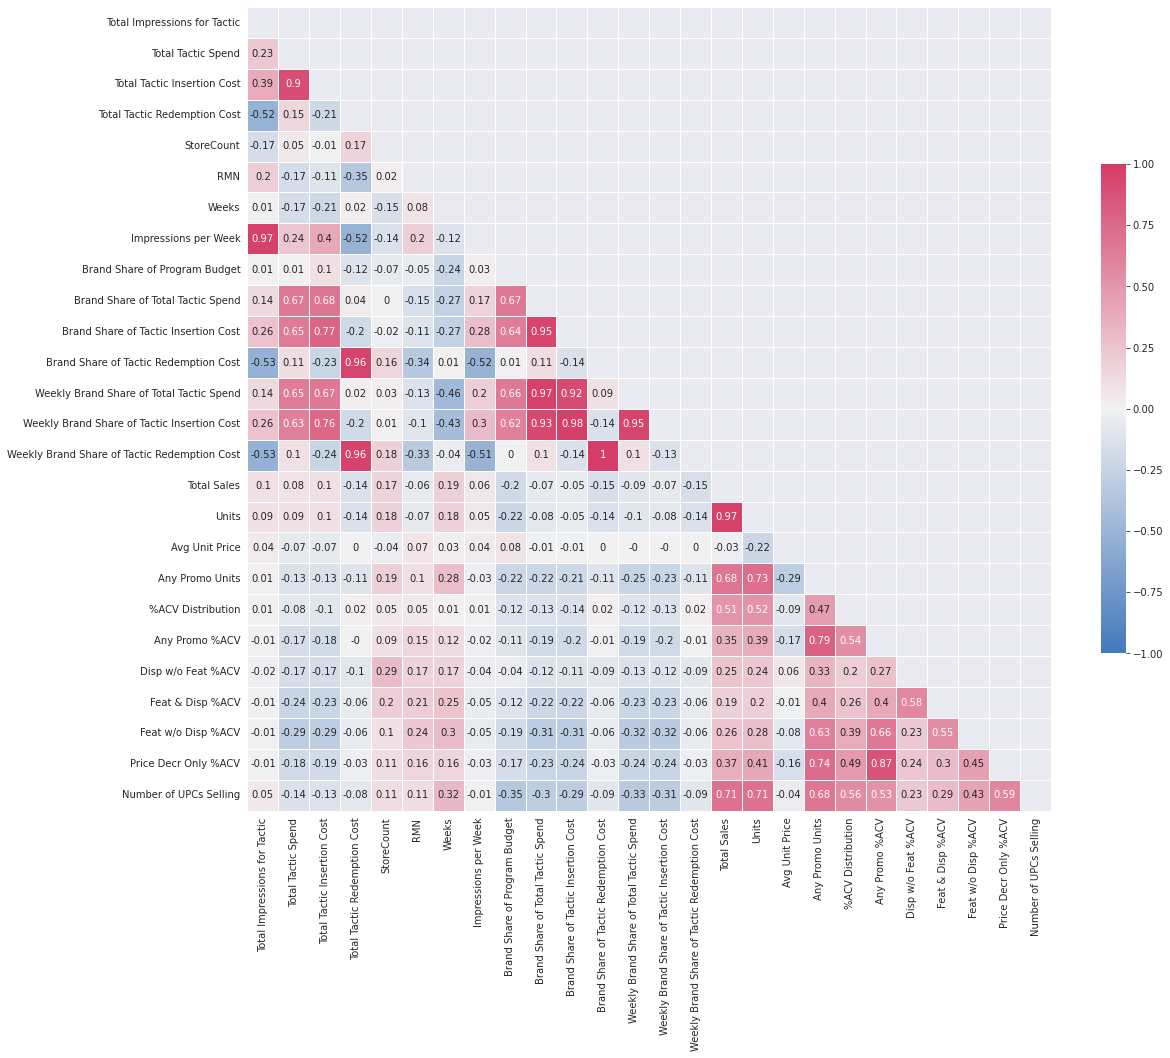

In [9]:
corr = df_num.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

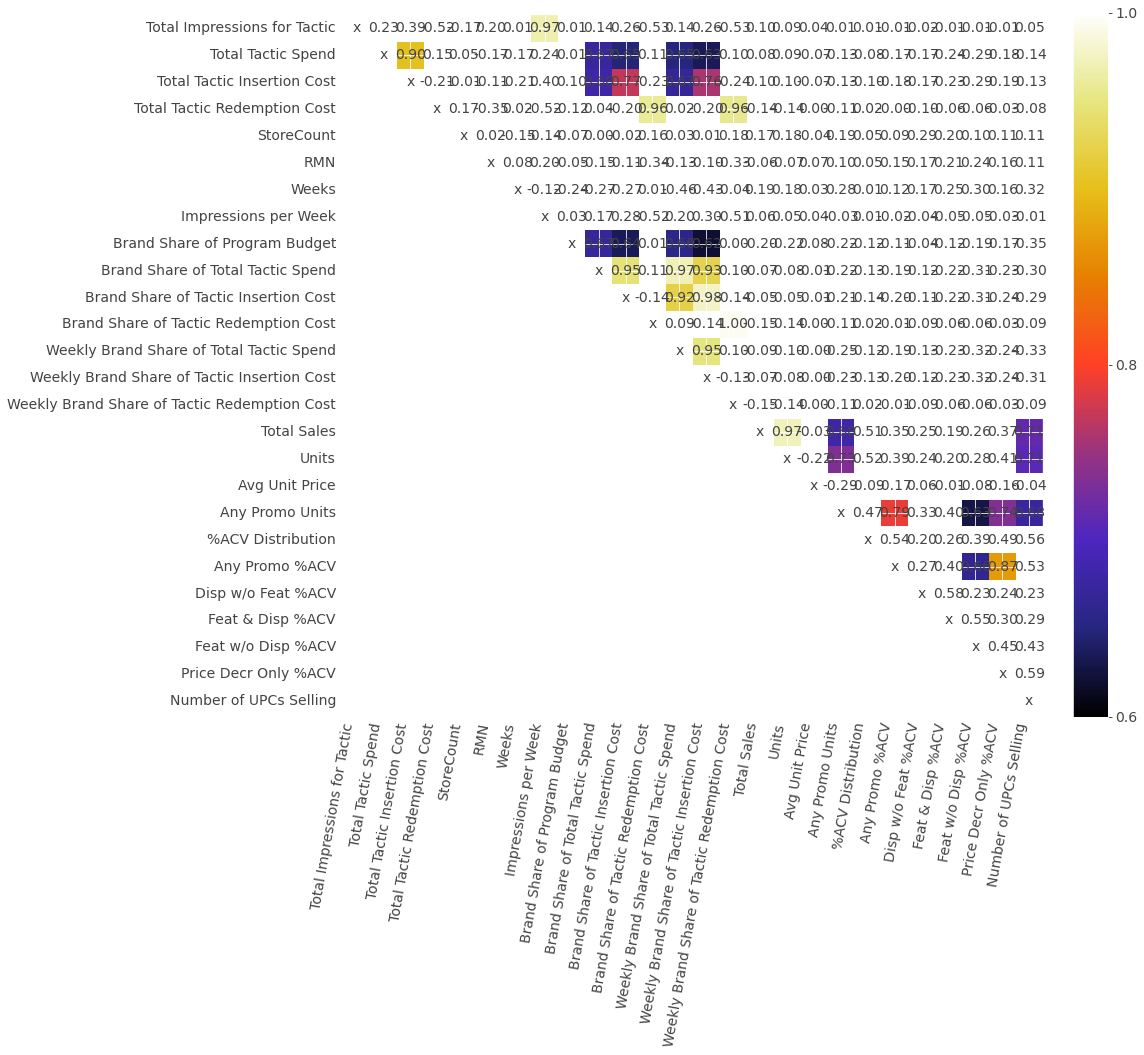

In [10]:
viz = plot_corr_heatmap(df_num, cmap='CMRmap', value_fontsize=14,
                        label_fontsize=14, figsize=(16, 16))
viz.view()

In [11]:
def imp_plots(target, features):
    """Form three importance plots

    :param target:'dependent' component
    :param features:'predictive' component
    """
    target = target
    df_all = df_num.dropna().astype(dtype='int32')
    df_all = df_all[features + [target]]
    df_train, df_test = train_test_split(df_all, test_size=0.15)
    X_train, y_train = df_train.drop(target, axis=1), df_train[target]
    X_test, y_test = df_test.drop(target, axis=1), df_test[target]
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                max_features=1.0,
                                min_samples_leaf=10, oob_score=True)
    rf.fit(X_train, y_train)
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                           max_depth=None, max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                           oob_score=True, random_state=None, verbose=0, warm_start=False)
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    imp1 = importances(rf, X_test, y_test)
    plot_importances(imp1, width=16, vscale=4, ax=ax1)

    imp = pd.DataFrame()
    imp['Feature'] = X_train.columns
    imp['Importance'] = rf.feature_importances_
    imp = imp.sort_values('Importance', ascending=False)
    imp2 = imp.set_index('Feature')
    plot_importances(imp2, width=16, vscale=4, ax=ax2)

    perm_importance = permutation_importance(rf, X_test, y_test)
    perm = pd.DataFrame()
    perm['Feature'] = X_test.columns
    perm['Importance'] = perm_importance.importances_mean
    perm = perm.sort_values('Importance', ascending=False)
    perm = perm.set_index('Feature')
    plot_importances(perm, width=16, vscale=4, ax=ax3)
    a = imp1.sort_values(by='Feature')
    b = imp2.sort_values(by='Feature')
    c = perm.sort_values(by='Feature')
    d = (a + b + c).sort_values('Importance', ascending=False).mean(axis=1)
    plt.show()
    return d

Here we use the correlation df and filter by a minimum threshold, while
eliminating one to avoid including the variable itself
by converting it to a list, we can use it in our feature importance plots

The following three importance plots look at different ways to measure importance
in relation to predicting our variable of interest. We can continue this
process many times to develop our Bayesian Hierarchy

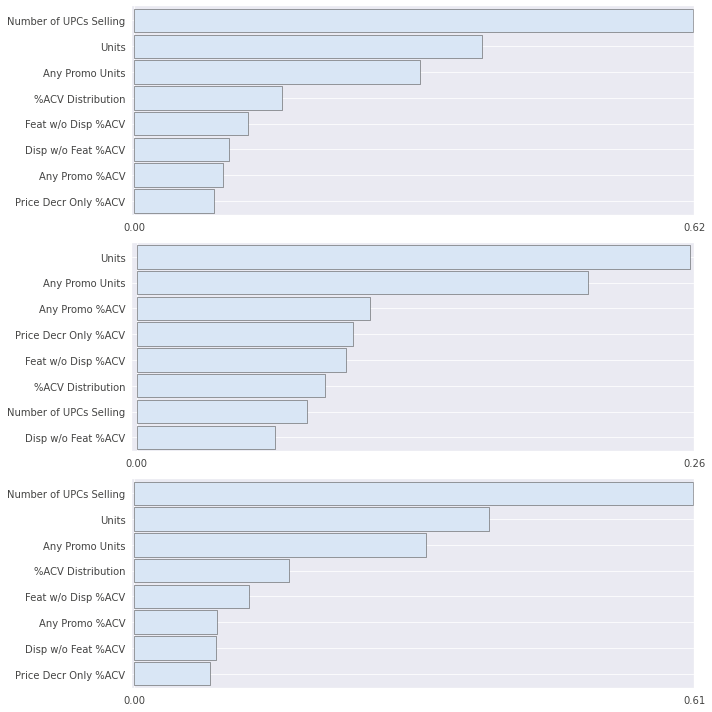

Feature
Number of UPCs Selling    1.310519
Units                     1.030016
Any Promo Units           0.845518
%ACV Distribution         0.420639
Feat w/o Disp %ACV        0.348736
Any Promo %ACV            0.298002
Price Decr Only %ACV      0.272131
Disp w/o Feat %ACV        0.258362
dtype: float64


In [12]:
corr_imp = corr[abs(corr['Total Sales'] > .2) & (corr['Total Sales'] < 1.0)]
corr_imp = corr_imp[['Total Sales']]
features = corr_imp.index.tolist()
imp_sales = imp_plots('Total Sales', features)
print(imp_sales)

Once the previous importance plots have given us insight into the most important
variables at that level of the hierarchy, we can continue by choosing the most important
for the next level of the hierarchy

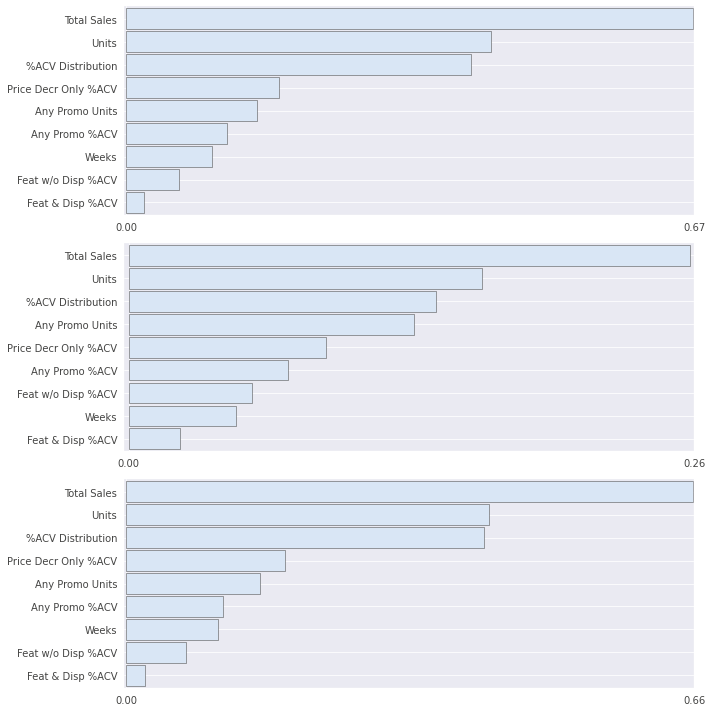

Feature
Total Sales             1.588919
Units                   1.017068
%ACV Distribution       0.965993
Price Decr Only %ACV    0.456787
Any Promo Units         0.443070
Any Promo %ACV          0.306096
Weeks                   0.258572
Feat w/o Disp %ACV      0.190401
Feat & Disp %ACV        0.067594
dtype: float64


In [13]:
corr_imp = corr[
    abs(corr['Number of UPCs Selling'] > .25) & (corr['Number of UPCs Selling'] < 1.0)]
corr_imp = corr_imp[['Number of UPCs Selling']]
features = corr_imp.index.tolist()
imp_UPC = imp_plots('Number of UPCs Selling', features)
print(imp_UPC)

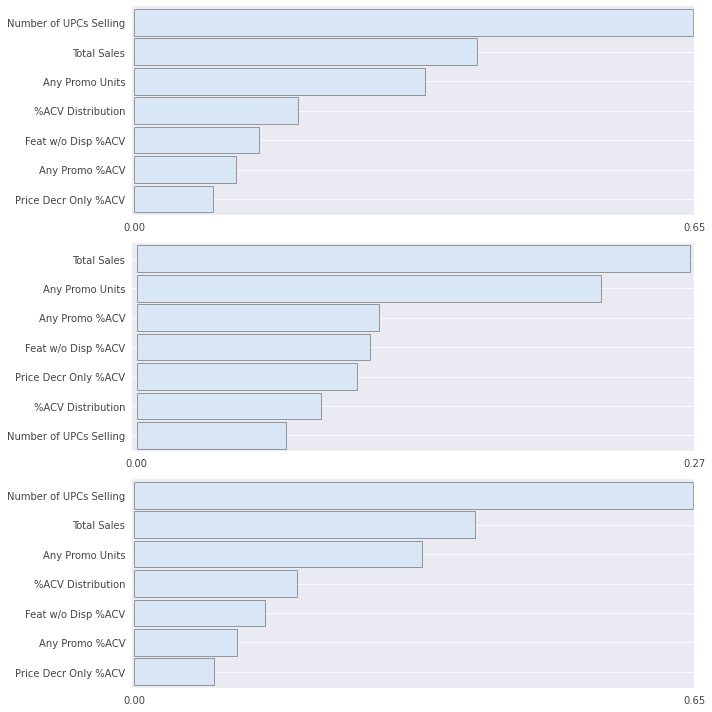

Feature
Number of UPCs Selling    1.360509
Total Sales               1.057497
Any Promo Units           0.893053
%ACV Distribution         0.466940
Feat w/o Disp %ACV        0.408336
Any Promo %ACV            0.353689
Price Decr Only %ACV      0.290630
dtype: float64


In [14]:
corr_imp = corr[abs(corr['Units'] > .25) & (corr['Units'] < 1.0)]
corr_imp = corr_imp[['Units']]
features = corr_imp.index.tolist()
imp_units = imp_plots('Units', features)
print(imp_units)

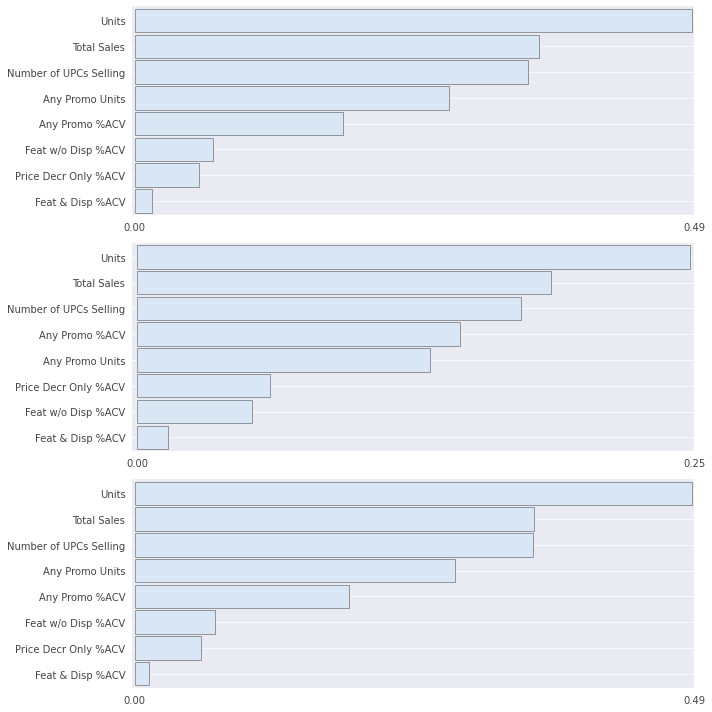

Feature
Units                     1.230149
Total Sales               0.893307
Number of UPCs Selling    0.868964
Any Promo Units           0.690128
Any Promo %ACV            0.516571
Feat w/o Disp %ACV        0.190579
Price Decr Only %ACV      0.173906
Feat & Disp %ACV          0.041407
dtype: float64


In [15]:
corr_imp = corr[abs(corr['%ACV Distribution'] > .25) & (corr['%ACV Distribution'] < 1.0)]
corr_imp = corr_imp[['%ACV Distribution']]
features = corr_imp.index.tolist()
imp_ACV_Dist = imp_plots('%ACV Distribution', features)
print(imp_ACV_Dist)

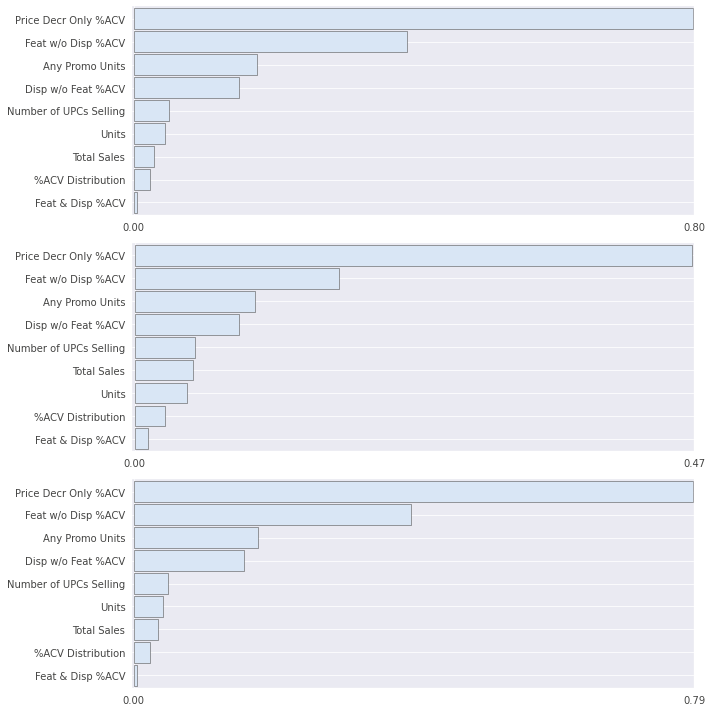

Feature
Price Decr Only %ACV      2.057457
Feat w/o Disp %ACV        0.955011
Any Promo Units           0.451811
Disp w/o Feat %ACV        0.393363
Number of UPCs Selling    0.149608
Units                     0.130540
Total Sales               0.111991
%ACV Distribution         0.069970
Feat & Disp %ACV          0.021088
dtype: float64


In [16]:
corr_imp = corr[abs(corr['Any Promo %ACV'] > .25) & (corr['Any Promo %ACV'] < 1.0)]
corr_imp = corr_imp[['Any Promo %ACV']]
features = corr_imp.index.tolist()
imp_promo_ACV = imp_plots('Any Promo %ACV', features)
print(imp_promo_ACV)

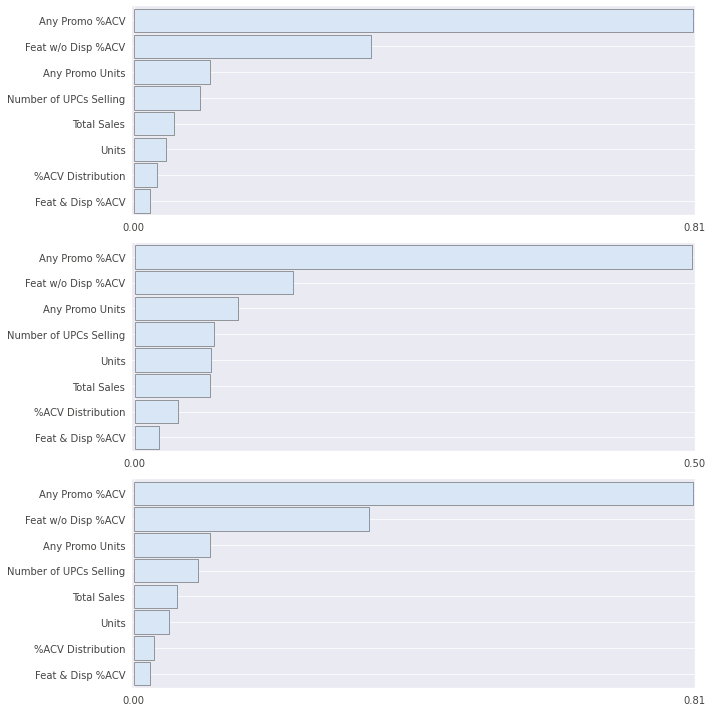

Feature
Any Promo %ACV            2.119953
Feat w/o Disp %ACV        0.826688
Any Promo Units           0.313795
Number of UPCs Selling    0.261023
Total Sales               0.188165
Units                     0.167005
%ACV Distribution         0.102145
Feat & Disp %ACV          0.068996
dtype: float64


In [17]:
corr_imp = corr[abs(corr['Price Decr Only %ACV'] > .25) & (corr['Price Decr Only %ACV'] < 1.0)]
corr_imp = corr_imp[['Price Decr Only %ACV']]
features = corr_imp.index.tolist()
imp_price_decr = imp_plots('Price Decr Only %ACV', features)
print(imp_price_decr)

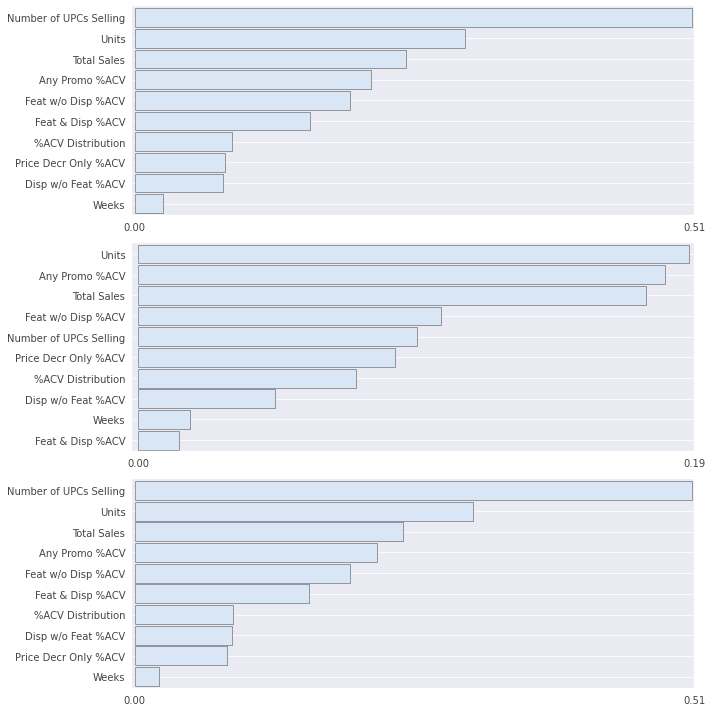

Feature
Number of UPCs Selling    1.118609
Units                     0.803960
Total Sales               0.671015
Any Promo %ACV            0.621691
Feat w/o Disp %ACV        0.500341
Feat & Disp %ACV          0.334572
Price Decr Only %ACV      0.256778
%ACV Distribution         0.255766
Disp w/o Feat %ACV        0.217567
Weeks                     0.066366
dtype: float64


In [18]:
corr_imp = corr[abs(corr['Any Promo Units'] > .25) & (corr['Any Promo Units'] < 1.0)]
corr_imp = corr_imp[['Any Promo Units']]
features = corr_imp.index.tolist()
imp_promo_unit = imp_plots('Any Promo Units', features)
print(imp_promo_unit)

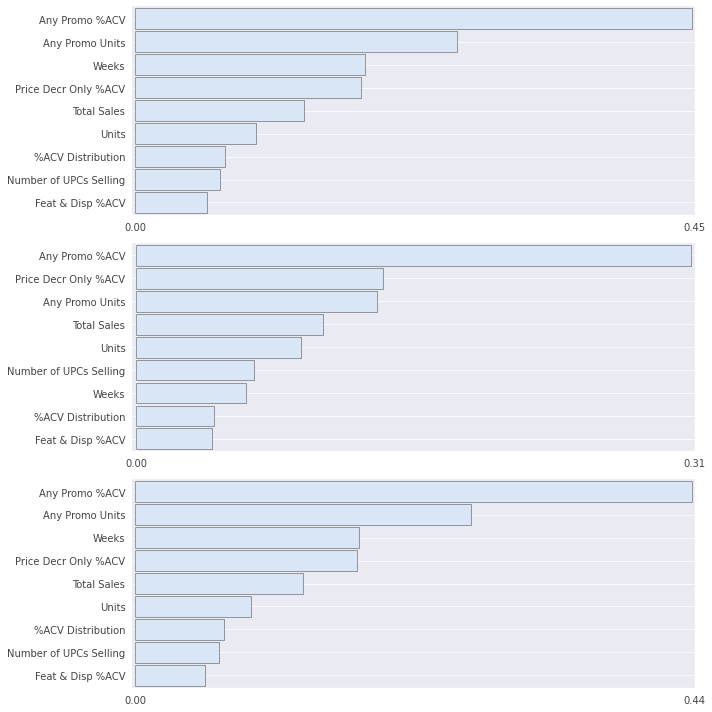

Feature
Any Promo %ACV            1.196272
Any Promo Units           0.657269
Price Decr Only %ACV      0.493610
Weeks                     0.421773
Total Sales               0.372852
Units                     0.280874
Number of UPCs Selling    0.201182
%ACV Distribution         0.185956
Feat & Disp %ACV          0.155782
dtype: float64


In [19]:
corr_imp = corr[abs(corr['Feat w/o Disp %ACV'] > .25) & (corr['Feat w/o Disp %ACV'] < 1.0)]
corr_imp = corr_imp[['Feat w/o Disp %ACV']]
features = corr_imp.index.tolist()
imp_feat_no_disp = imp_plots('Feat w/o Disp %ACV', features)
print(imp_feat_no_disp)

This can be repeated for every variable of interest in the hierarchy
The below kde plots are crucial to understanding the likelihood function
distribution and beginning the Bayesian modeling

In [20]:
final_vars = ['Number of UPCs Selling', 'Units', 'Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Any Promo %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'Weeks']

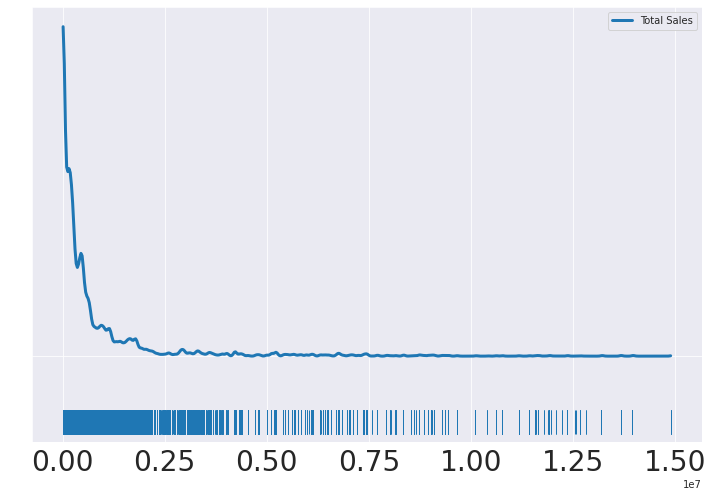

In [21]:
az.plot_kde(df['Total Sales'].values, rug=True, label='Total Sales', figsize=(12, 8))
plt.yticks([0], alpha=0);
# most likely gamma

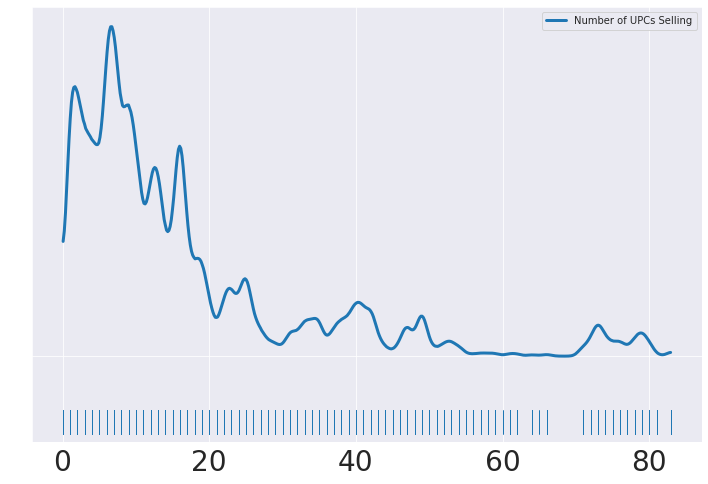

In [22]:
az.plot_kde(df['Number of UPCs Selling'].values, rug=True, label='Number of UPCs Selling', figsize=(12, 8))
plt.yticks([0], alpha=0);

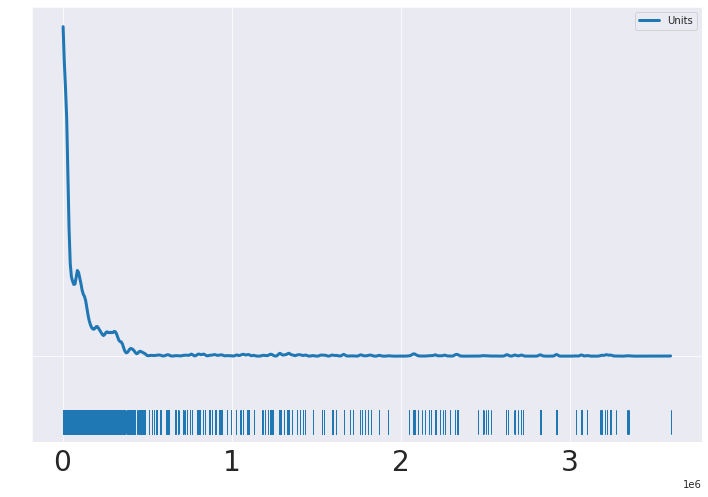

In [23]:
az.plot_kde(df['Units'].values, rug=True, label='Units', figsize=(12, 8))
plt.yticks([0], alpha=0);

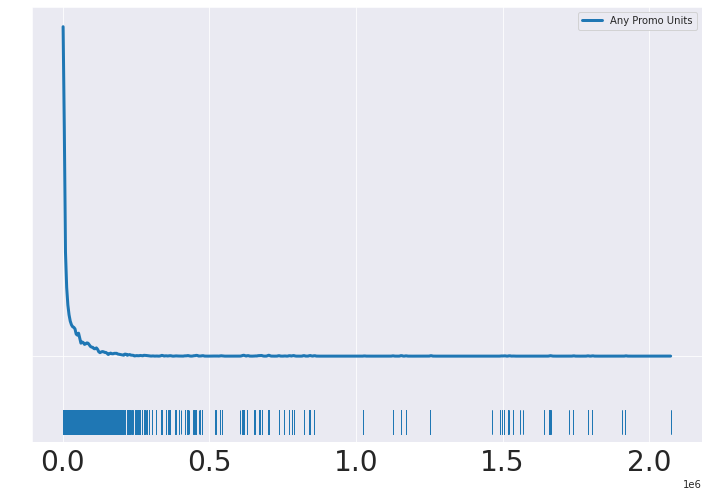

In [24]:
az.plot_kde(df['Any Promo Units'].values, rug=True, label='Any Promo Units', figsize=(12, 8))
plt.yticks([0], alpha=0);

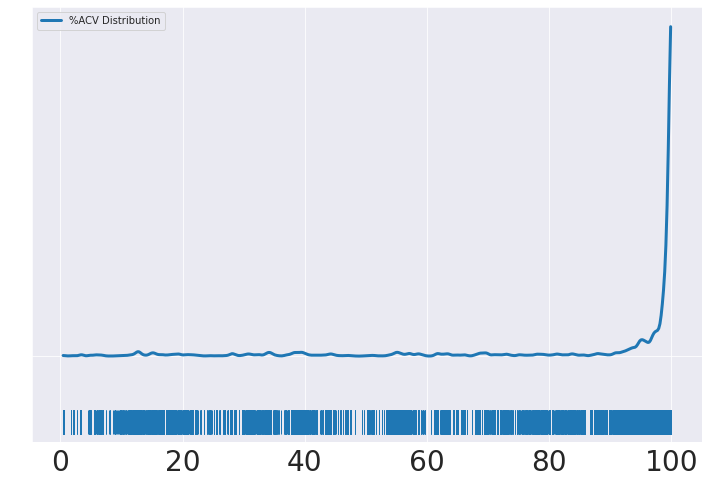

In [25]:
az.plot_kde(df['%ACV Distribution'].values, rug=True, label='%ACV Distribution', figsize=(12, 8))
plt.yticks([0], alpha=0);

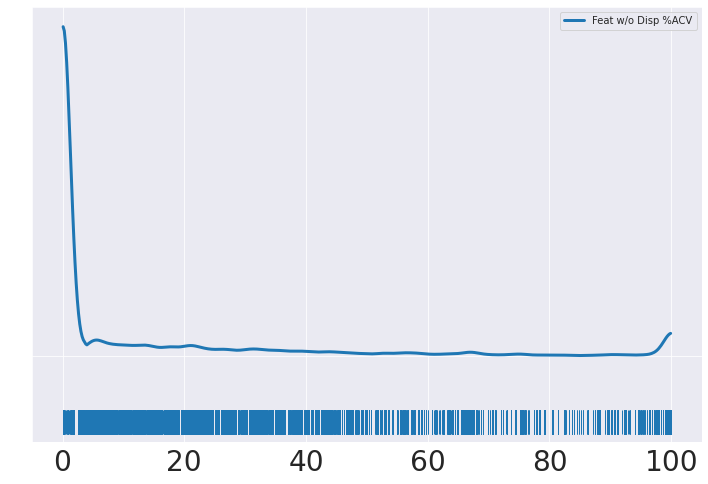

In [26]:
az.plot_kde(df['Feat w/o Disp %ACV'].values, rug=True, label='Feat w/o Disp %ACV', figsize=(12, 8))
plt.yticks([0], alpha=0);

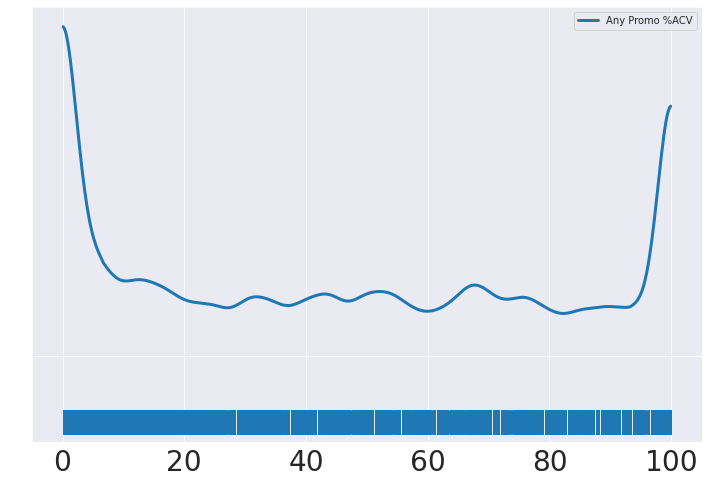

In [27]:
az.plot_kde(df['Any Promo %ACV'].values, rug=True, label='Any Promo %ACV', figsize=(12, 8))
plt.yticks([0], alpha=0);

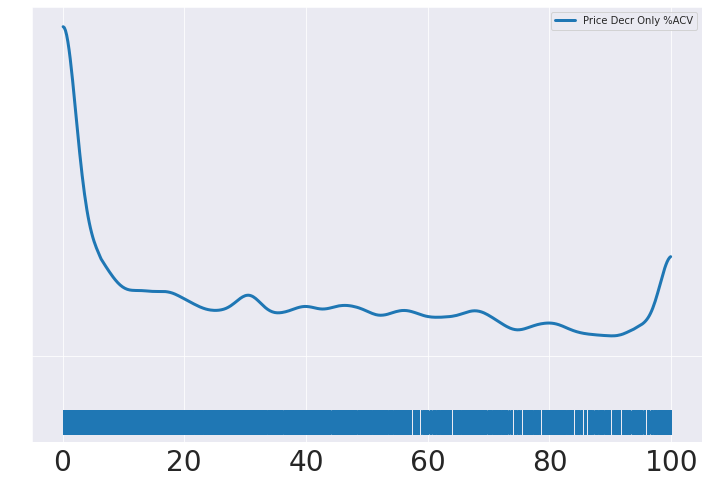

In [28]:
az.plot_kde(df['Price Decr Only %ACV'].values, rug=True, label='Price Decr Only %ACV', figsize=(12, 8))
plt.yticks([0], alpha=0);

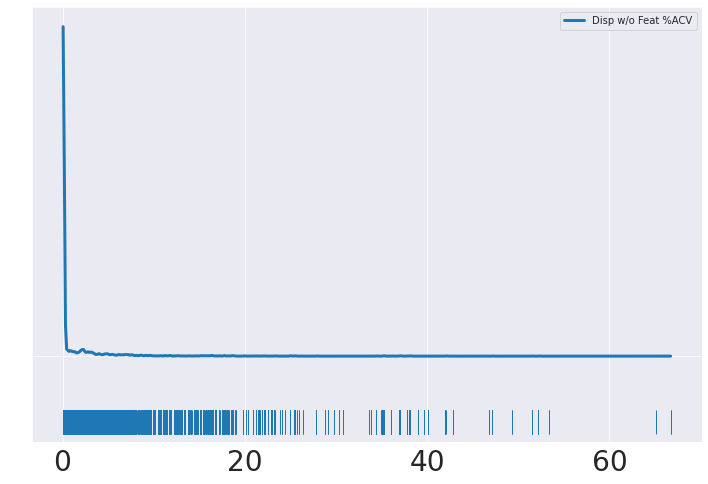

In [29]:
az.plot_kde(df['Disp w/o Feat %ACV'].values, rug=True, label='Disp w/o Feat %ACV', figsize=(12, 8))
plt.yticks([0], alpha=0);

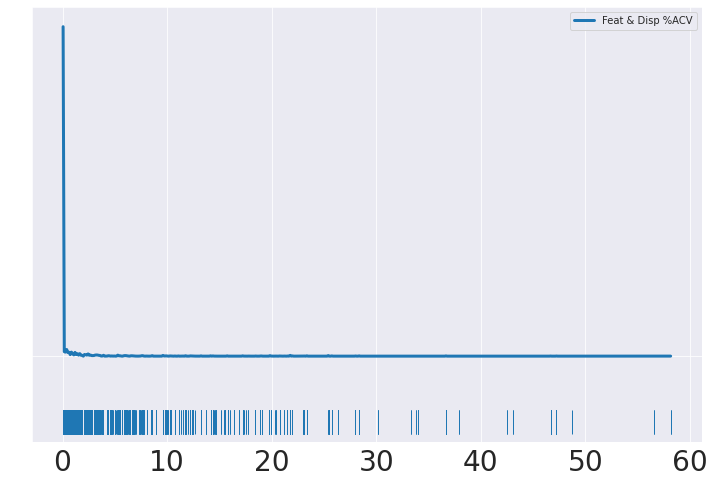

In [30]:
az.plot_kde(df['Feat & Disp %ACV'].values, rug=True, label='Feat & Disp %ACV', figsize=(12, 8))
plt.yticks([0], alpha=0);

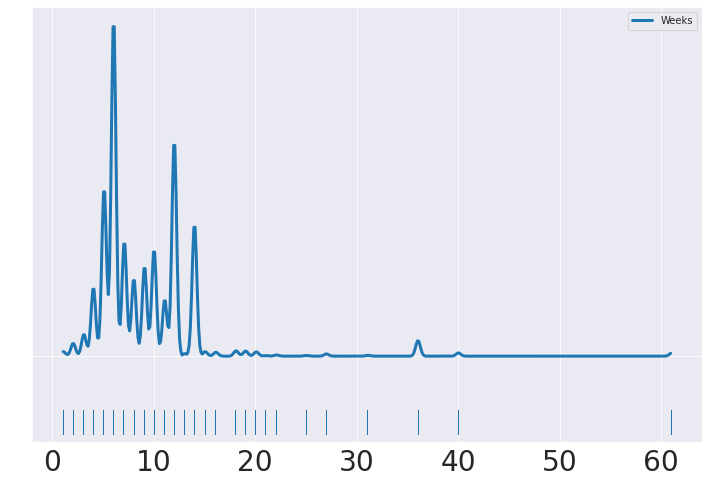

In [31]:
az.plot_kde(df['Weeks'].values, rug=True, label='Weeks', figsize=(12, 8))
plt.yticks([0], alpha=0);

In [32]:
# removing all zeroes for the initial testing

df_sales_nz = df[df['Total Sales'] > 0.0]
print(df_sales_nz[df_sales_nz['Total Sales'] == 0.0])

Empty DataFrame
Columns: [Program Name, Retailers, Tactic, Tactic Category, Vendor, Total Impressions for Tactic, Total Tactic Spend, Total Tactic Insertion Cost, Total Tactic Redemption Cost, Tactic Start Date, Tactic End Date, Brand, StoreCount, RMN, Weeks, Impressions per Week, Brand Share of Program Budget, Brand Share of Total Tactic Spend, Brand Share of Tactic Insertion Cost, Brand Share of Tactic Redemption Cost, Weekly Brand Share of Total Tactic Spend, Weekly Brand Share of Tactic Insertion Cost, Weekly Brand Share of Tactic Redemption Cost, Total Sales, Units, Avg Unit Price, Any Promo Units, %ACV Distribution, Any Promo %ACV, Disp w/o Feat %ACV, Feat & Disp %ACV, Feat w/o Disp %ACV, Price Decr Only %ACV, Number of UPCs Selling]
Index: []

[0 rows x 34 columns]


In [33]:
with pm.Model() as model_sales:
    alpha = pm.Exponential('alpha', 100)
    beta = pm.Exponential('beta', 1000)
    g = pm.Gamma('g', alpha=alpha, beta=beta, observed=df_sales_nz['Total Sales'].values)
    trace_sales = pm.sample(5000, tune=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 13 seconds.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

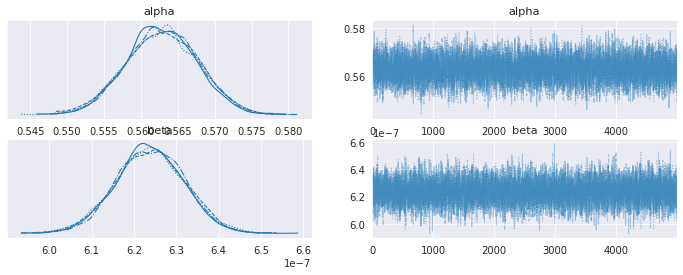

In [34]:
az.plot_trace(trace_sales)

In [35]:
az.summary(trace_sales)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.563,0.005,0.554,0.572,0.0,0.0,7760.0,9751.0,1.0
beta,0.000,0.000,0.000,0.000,0.0,0.0,7571.0,9216.0,1.0


In [36]:
az.mcse(trace_sales)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 5.511e-05
    beta     float64 9.28e-11

In [37]:
az.ess(trace_sales)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 7.76e+03
    beta     float64 7.571e+03

In [ ]:
az.plot_forest(trace_sales, var_names=['alpha', 'beta'], combined=True);

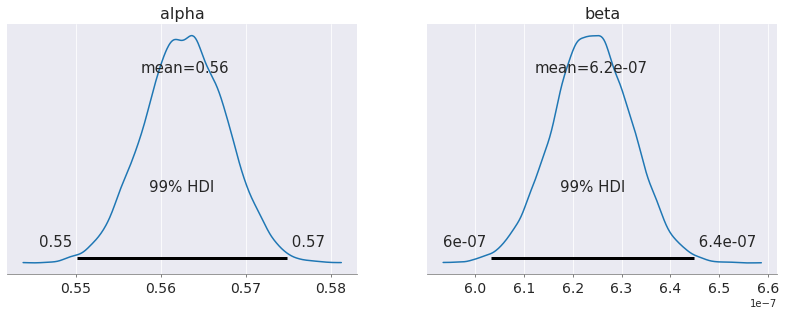

In [38]:
az.plot_posterior(trace_sales, hdi_prob=0.99);

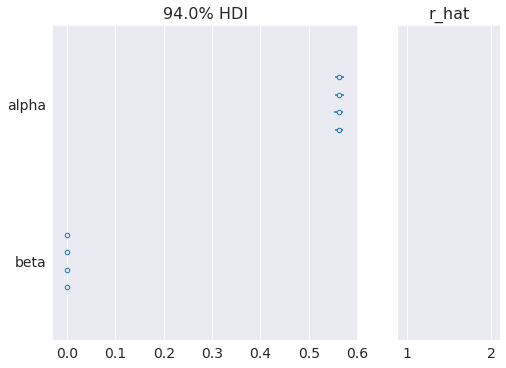

In [39]:
az.plot_forest(trace_sales, r_hat=True);

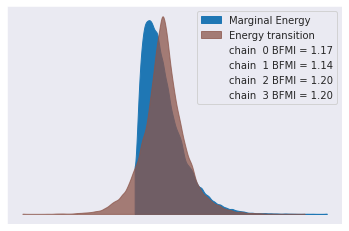

In [40]:
az.plot_energy(trace_sales);

# check on the exact definition of this

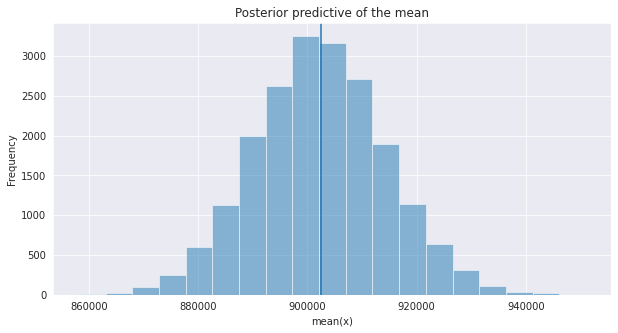

In [41]:
ppc = pm.sample_posterior_predictive(trace_sales, samples=20000, model=model_sales)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([g.mean() for g in ppc['g']], bins=19, alpha=0.5)
ax.axvline(df_sales_nz['Total Sales'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');